In [1]:
import pandas as pd
file_path = r'C:\Files\Developer\Sales_Time_Series\sample-sales-data\sales_data_sample.csv'

In [2]:
sales_data = pd.read_csv(file_path, encoding='latin1')
print(sales_data.head())

   ORDERNUMBER  QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  \
0        10107               30      95.70                2  2871.00   
1        10121               34      81.35                5  2765.90   
2        10134               41      94.74                2  3884.34   
3        10145               45      83.26                6  3746.70   
4        10159               49     100.00               14  5205.27   

         ORDERDATE   STATUS  QTR_ID  MONTH_ID  YEAR_ID  ...  \
0   2/24/2003 0:00  Shipped       1         2     2003  ...   
1    5/7/2003 0:00  Shipped       2         5     2003  ...   
2    7/1/2003 0:00  Shipped       3         7     2003  ...   
3   8/25/2003 0:00  Shipped       3         8     2003  ...   
4  10/10/2003 0:00  Shipped       4        10     2003  ...   

                    ADDRESSLINE1  ADDRESSLINE2           CITY STATE  \
0        897 Long Airport Avenue           NaN            NYC    NY   
1             59 rue de l'Abbaye           NaN

In [3]:
import matplotlib.pyplot as plt

In [4]:
sales_data['ORDERDATE'] = pd.to_datetime(sales_data['ORDERDATE'], errors='coerce')

In [5]:
cleaned_data = sales_data[['ORDERDATE', 'SALES']].copy()

In [6]:
#Calculate IQR
Q1 = cleaned_data['SALES'].quantile(0.25)
Q3 = cleaned_data['SALES'].quantile(0.75)
IQR = Q3 - Q1

#Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

#Remove outliers
filtered_data = cleaned_data[(cleaned_data['SALES'] >= lower_bound) & (cleaned_data['SALES'] <= upper_bound)]


In [7]:
time_series_data = filtered_data.groupby('ORDERDATE', as_index=False).sum()

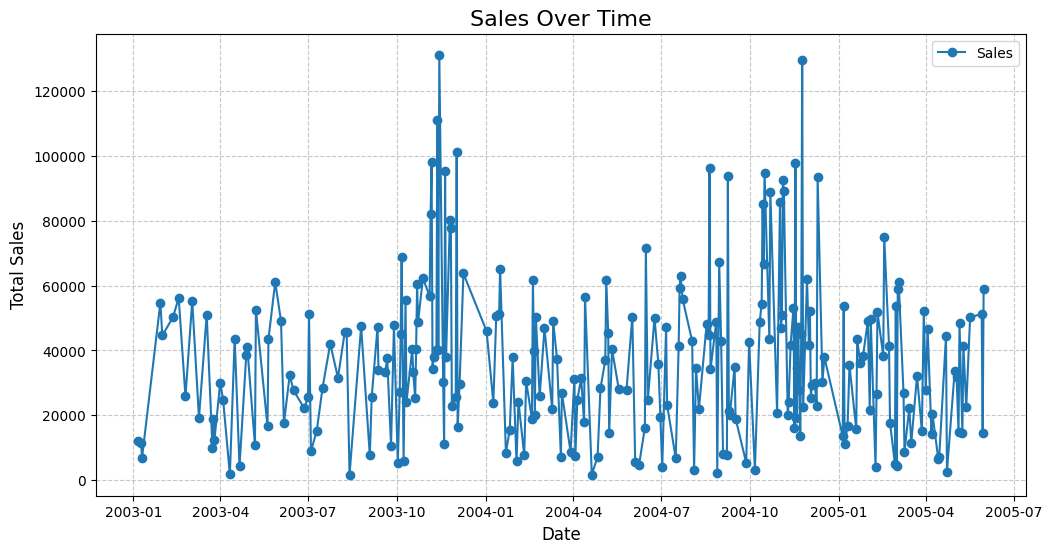

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(time_series_data['ORDERDATE'], time_series_data['SALES'], marker='o', linestyle='-', label='Sales')
plt.title('Sales Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

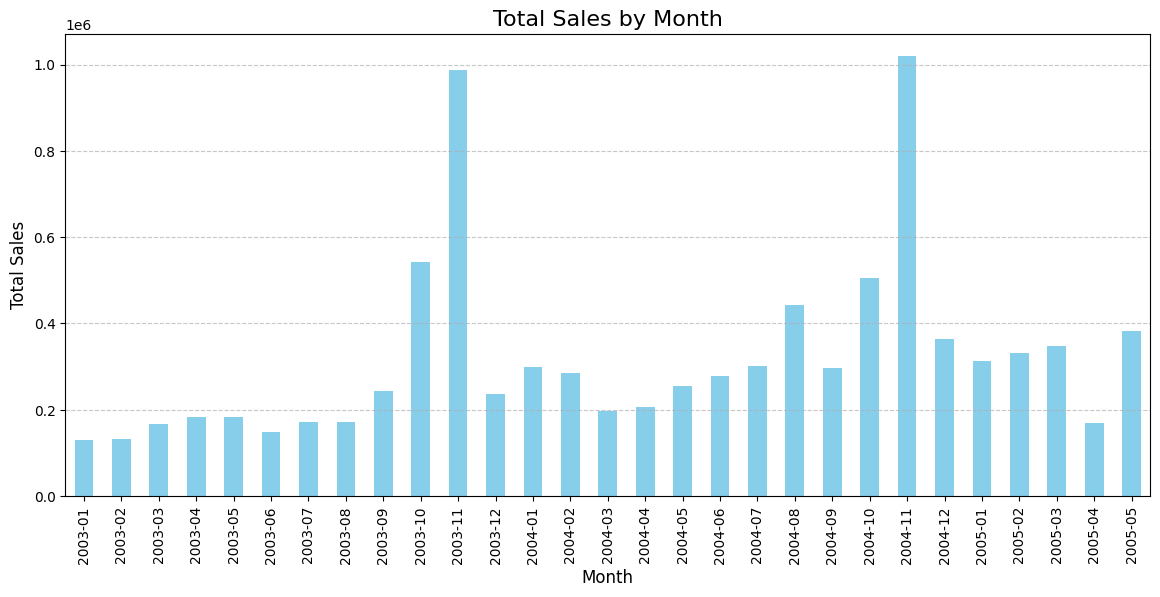

In [9]:
time_series_data['Month'] = time_series_data['ORDERDATE'].dt.to_period('M')
monthly_sales = time_series_data.groupby('Month')['SALES'].sum()

plt.figure(figsize=(14, 6))
monthly_sales.plot(kind='bar', color='skyblue')
plt.title('Total Sales by Month', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [10]:
time_series_data['SALES'].describe()

count       252.000000
mean      36863.811786
std       24433.565922
min        1637.200000
25%       18928.992500
50%       34228.410000
75%       49686.012500
max      131236.000000
Name: SALES, dtype: float64

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [12]:
time_series_data = time_series_data.set_index('ORDERDATE')

In [13]:
result = seasonal_decompose(time_series_data['SALES'], model='additive', period=30)  # Assuming ~30 days in a month

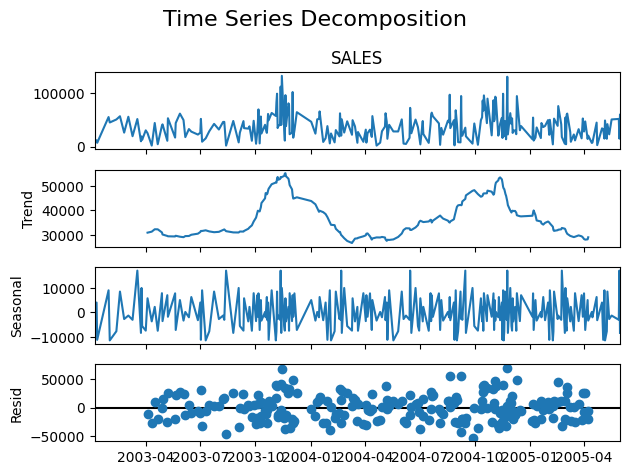

In [14]:
#Plotting the decomposed components
result.plot()
plt.suptitle('Time Series Decomposition', fontsize=16)
plt.tight_layout()
plt.show()

In [15]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
import numpy as np

In [16]:
#Split point
split_point = int(len(time_series_data) * 0.8)

#Data split
train = time_series_data[:split_point]
test = time_series_data[split_point:]

In [17]:
#Daily frequency
time_series_data = time_series_data.asfreq('D')

import warnings
warnings.filterwarnings("ignore")

#Fitting the ARIMA model
model = ARIMA(train['SALES'], order=(2, 1, 2))
fitted_model = model.fit()

print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  SALES   No. Observations:                  201
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2309.764
Date:                Mon, 27 Jan 2025   AIC                           4629.529
Time:                        12:47:37   BIC                           4646.020
Sample:                             0   HQIC                          4636.203
                                - 201                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0180      0.282     -3.610      0.000      -1.571      -0.465
ar.L2         -0.0950      0.100     -0.945      0.345      -0.292       0.102
ma.L1          0.0178      0.278      0.064      0.9

In [18]:
#Forecasting sales
forecast = fitted_model.forecast(steps=len(test))

# Evaluating the model using Mean Absolute Error
mae = mean_absolute_error(test['SALES'], forecast)
print(f"Mean Absolute Error: {mae}")


Mean Absolute Error: 19134.15196767558


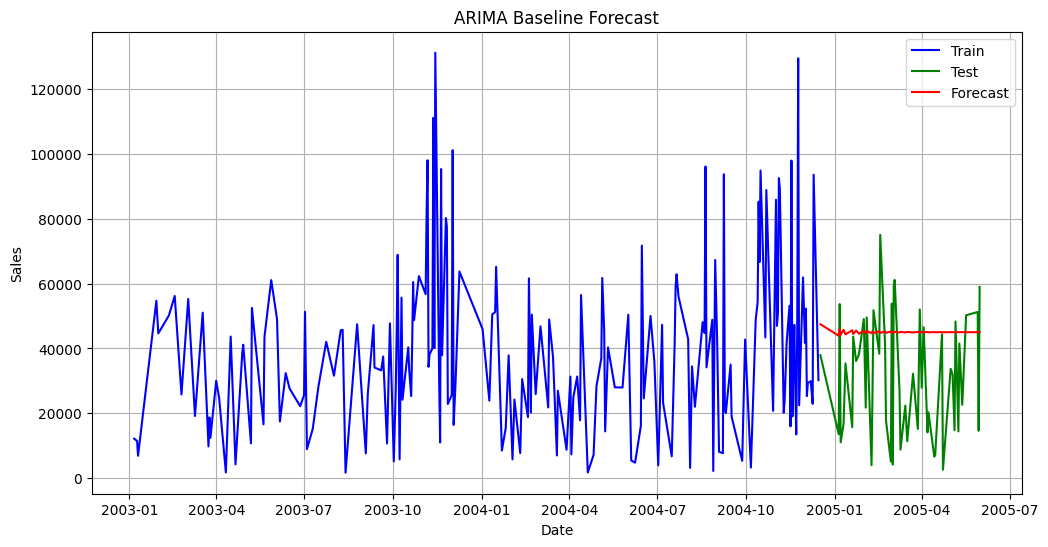

In [19]:
#Plot actual vs predicted sales
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['SALES'], label='Train', color='blue')
plt.plot(test.index, test['SALES'], label='Test', color='green')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.title('ARIMA Baseline Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.show()


In [20]:
from itertools import product

#Define the range of parameters to search
p = range(0, 4)  # Test p from 0 to 3
d = range(0, 2)  # Test d as 0 or 1
q = range(0, 4)  # Test q from 0 to 3

#Create a grid of all combinations of p, d, q
pdq_combinations = list(product(p, d, q))

#Initialize variables to track the best model
best_aic = float("inf")
best_order = None
best_model = None

#Loop through all combinations and evaluate ARIMA models
for order in pdq_combinations:
    try:
        model = ARIMA(train['SALES'], order=order)
        fitted = model.fit()
        if fitted.aic < best_aic:  # Select the model with the lowest AIC
            best_aic = fitted.aic
            best_order = order
            best_model = fitted
    except Exception as e:
        continue  # Skip combinations that fail to converge

print(f"Best ARIMA order: {best_order} with AIC: {best_aic}")


Best ARIMA order: (2, 1, 3) with AIC: 4624.763054033143


In [21]:
#Fitting the optimized ARIMA model
optimized_model = ARIMA(train['SALES'], order=(2, 1, 3))
optimized_fitted = optimized_model.fit()

print(optimized_fitted.summary())


                               SARIMAX Results                                
Dep. Variable:                  SALES   No. Observations:                  201
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -2306.382
Date:                Mon, 27 Jan 2025   AIC                           4624.763
Time:                        12:48:55   BIC                           4644.553
Sample:                             0   HQIC                          4632.772
                                - 201                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4365      0.044    -10.020      0.000      -0.522      -0.351
ar.L2         -0.9280      0.041    -22.622      0.000      -1.008      -0.848
ma.L1         -0.5266      0.043    -12.213      0.0

In [22]:
#Forecasting sales of optimized model
optimized_forecast = optimized_fitted.forecast(steps=len(test))

#Evaluating the optimized model using MAE
optimized_mae = mean_absolute_error(test['SALES'], optimized_forecast)
print(f"Optimized Model MAE: {optimized_mae}")


Optimized Model MAE: 18825.484862841993


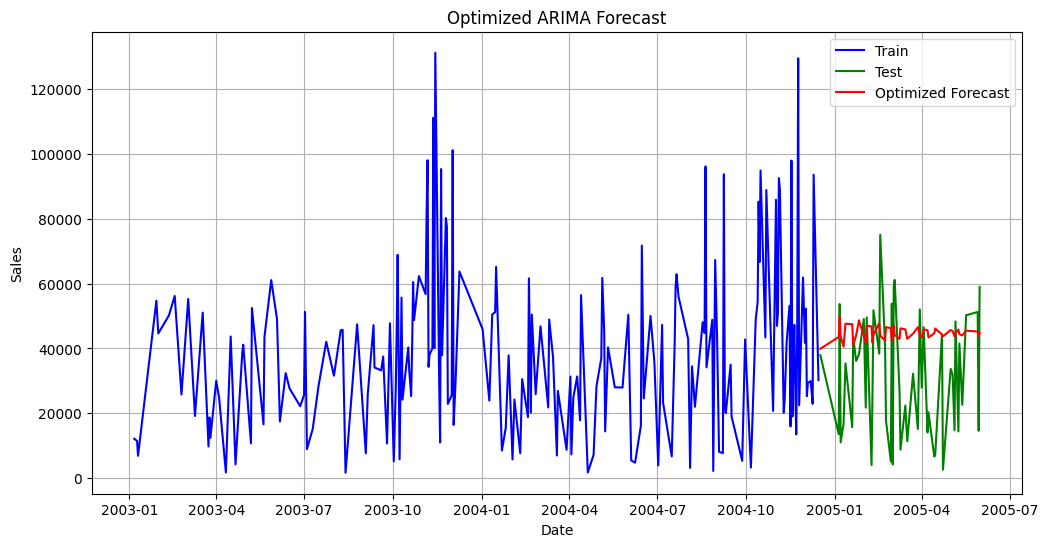

In [23]:
#Plot actual vs optimized forecast
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['SALES'], label='Train', color='blue')
plt.plot(test.index, test['SALES'], label='Test', color='green')
plt.plot(test.index, optimized_forecast, label='Optimized Forecast', color='red')
plt.title('Optimized ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.show()

In [24]:
from prophet import Prophet

In [25]:
prophet_data = time_series_data.reset_index()[['ORDERDATE', 'SALES']].rename(columns={
    'ORDERDATE': 'ds',
    'SALES': 'y'
})

In [26]:
model = Prophet()

#Fitting the model
model.fit(prophet_data)


12:49:10 - cmdstanpy - INFO - Chain [1] start processing
12:49:10 - cmdstanpy - INFO - Chain [1] done processing


In [27]:
#Creating a DataFrame for 90 days in future
future = model.make_future_dataframe(periods=90)

#Forecasting sales
prophet_forecast = model.predict(future)

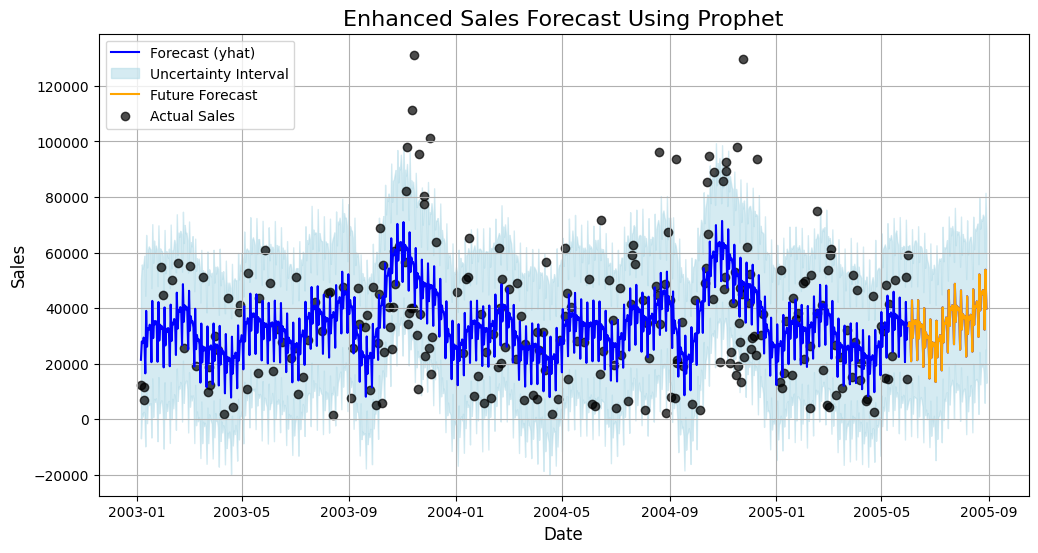

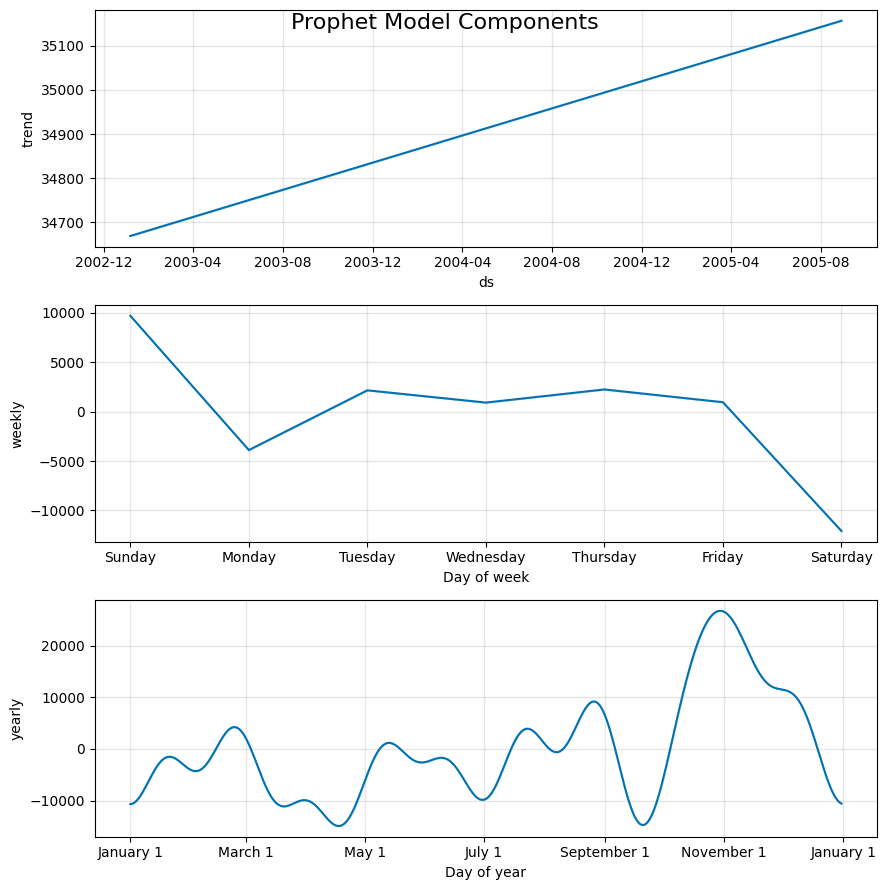

In [28]:
#Plotting the forecast
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(prophet_forecast['ds'], prophet_forecast['yhat'], label='Forecast (yhat)', color='blue')
ax.fill_between(
    prophet_forecast['ds'], 
    prophet_forecast['yhat_lower'], 
    prophet_forecast['yhat_upper'], 
    color='lightblue', 
    alpha=0.5, 
    label='Uncertainty Interval'
)
forecast_part = prophet_forecast[prophet_forecast['ds'] > prophet_data['ds'].max()]
ax.plot(forecast_part['ds'], forecast_part['yhat'], label='Future Forecast', color='orange')
ax.scatter(prophet_data['ds'], prophet_data['y'], label='Actual Sales', color='black', alpha=0.7)
ax.set_title('Enhanced Sales Forecast Using Prophet', fontsize=16)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Sales', fontsize=12)
ax.legend(loc='upper left', fontsize=10)
ax.grid(True)
plt.show()

#Components
fig_components = model.plot_components(prophet_forecast)
plt.suptitle('Prophet Model Components', fontsize=16)
plt.show()

In [31]:
#Extracting the forecasted values for the test period
forecast_test = prophet_forecast[prophet_forecast['ds'].isin(test.index)][['ds', 'yhat']]
forecast_test = forecast_test.set_index('ds')

#MAE Calculation
prophet_mae = mean_absolute_error(test['SALES'], forecast_test['yhat'])
print(f"Prophet Model MAE: {prophet_mae}")

Prophet Model MAE: 13720.40093438655


In [34]:
# Debugging: Verify prophet_forecast is a Series
print("Prophet forecast preview:")
print(prophet_forecast.head())  # Ensure it contains the forecast values

# Align Prophet forecast with test set
prophet_forecast = prophet_forecast.iloc[:len(test)]  # Truncate to match test length
prophet_forecast.index = test.index  # Align with test index

# Debugging: Check lengths and structure
print(f"Length of test['SALES']: {len(test['SALES'])}")
print(f"Length of forecast (ARIMA): {len(forecast)}")
print(f"Length of optimized_forecast (Optimized ARIMA): {len(optimized_forecast)}")
print(f"Length of prophet_forecast: {len(prophet_forecast)}")

# Create the forecasted DataFrame
forecasted_df = pd.DataFrame({
    'Date': test.index,
    'Actual_Sales': test['SALES'].values,
    'ARIMA_Forecast': forecast,
    'Optimized_ARIMA_Forecast': optimized_forecast,
    'Prophet_Forecast': prophet_forecast.values,  # Use .values to ensure clean array
    'ARIMA_Residuals': test['SALES'].values - forecast,
    'Optimized_ARIMA_Residuals': test['SALES'].values - optimized_forecast,
    'Prophet_Residuals': test['SALES'].values - prophet_forecast.values
})

# Preview the DataFrame
print(forecasted_df.head())


Prophet forecast preview:
ORDERDATE
2004-12-17    21352.124811
2005-01-05    27960.412306
2005-01-06    27347.197112
2005-01-07    29356.586587
2005-01-10    28775.529501
dtype: float64
Length of test['SALES']: 51
Length of forecast (ARIMA): 51
Length of optimized_forecast (Optimized ARIMA): 51
Length of prophet_forecast: 51
          Date  Actual_Sales  ARIMA_Forecast  Optimized_ARIMA_Forecast  \
201 2004-12-17      37905.15    47462.752223              39898.976600   
202 2005-01-05      13529.57    43901.598582              43531.886385   
203 2005-01-06      53690.93    45888.591502              49840.935635   
204 2005-01-07      11021.30    44204.087743              43715.995128   
205 2005-01-10      16628.16    45730.172436              40534.558441   

     Prophet_Forecast  ARIMA_Residuals  Optimized_ARIMA_Residuals  \
201      21352.124811     -9557.602223               -1993.826600   
202      27960.412306    -30372.028582              -30002.316385   
203      27347.197112

In [36]:
import sqlite3

# Connect to SQLite database
conn = sqlite3.connect('sales_forecasting.db')

# Reset the index to move ORDERDATE into the columns
time_series_data = time_series_data.reset_index()

# Convert ORDERDATE to datetime (if needed)
time_series_data['ORDERDATE'] = pd.to_datetime(time_series_data['ORDERDATE'], errors='coerce')

# Check and convert the 'Month' column if it is of type Period
if 'Month' in time_series_data.columns and isinstance(time_series_data['Month'].iloc[0], pd.Period):
    time_series_data['Month'] = time_series_data['Month'].astype(str)

# Save to SQLite
time_series_data.to_sql('sales_data', conn, if_exists='replace', index=False)

# Verify the table creation
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('sales_data',)]


In [37]:
#Aggregate sales by date
query = """
SELECT 
    ORDERDATE, 
    SUM(SALES) AS total_sales 
FROM 
    sales_data 
WHERE 
    SALES IS NOT NULL AND SALES > 0 
GROUP BY 
    ORDERDATE 
ORDER BY 
    ORDERDATE;
"""

cleaned_data_sql = pd.read_sql_query(query, conn)

print(cleaned_data_sql.head())


             ORDERDATE  total_sales
0  2003-01-06 00:00:00     12133.25
1  2003-01-09 00:00:00     11432.34
2  2003-01-10 00:00:00      6864.05
3  2003-01-29 00:00:00     54702.00
4  2003-01-31 00:00:00     44621.96


In [38]:
cleaned_data_sql.to_csv('cleaned_sales_data.csv', index=False)
print("Cleaned data exported to 'cleaned_sales_data.csv'")

Cleaned data exported to 'cleaned_sales_data.csv'


In [39]:
#Monthly data
monthly_query = """
SELECT 
    strftime('%Y-%m', ORDERDATE) AS month, 
    SUM(SALES) AS total_sales 
FROM 
    sales_data 
WHERE 
    SALES IS NOT NULL AND SALES > 0 
GROUP BY 
    month 
ORDER BY 
    month;
"""
monthly_data_sql = pd.read_sql_query(monthly_query, conn)

monthly_data_sql.to_csv('monthly_sales_data.csv', index=False)
print("Monthly data exported to 'monthly_sales_data.csv'")

Monthly data exported to 'monthly_sales_data.csv'


In [42]:
forecasted_df.to_sql('forecasted_sales', conn, if_exists='replace', index=False)
forecasted_df.to_csv('forecasted_sales.csv', index=False)

In [43]:
conn.close()